## xG model

This notebook demonstrates the key steps of our xG project. <br>
For detailed descriptions and methodology, please refer to the <a href='README.md'>README</a>.

In [28]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from modules.xG_constants import *
from modules.xG_preprocessing import Preprocessing
from modules.xG_visualization import Visualization
from modules.xG_models import ModelTrainer
from modules.xG_evaluation import ModelEvaluation

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.appName("xG_10").getOrCreate()

In [ ]:
PL = spark.read.csv('Dataset/events/England - Premier League.csv', inferSchema=True, header=True, sep=';')
L1 = spark.read.csv('Dataset/events/France - Ligue 1.csv', inferSchema=True, header=True, sep=';')
B1 = spark.read.csv('Dataset/events/Germany - 1. Bundesliga.csv', inferSchema=True, header=True, sep=';')
SA = spark.read.csv('Dataset/events/Italy - Serie A.csv', inferSchema=True, header=True, sep=';')
LL = spark.read.csv('Dataset/events/Spain - La Liga.csv', inferSchema=True, header=True, sep=';')

### Preprocessing

In [7]:
PL = Preprocessing(spark, PL)
L1 = Preprocessing(spark, L1)
B1 = Preprocessing(spark, B1)
SA = Preprocessing(spark, SA)
LL = Preprocessing(spark, LL)

25/02/28 17:59:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
print(f'We have {PL.df.count()} shots in the premier league for the {SEASON} season.')
print(f'We have {L1.df.count()} shots in the Ligue 1 for the {SEASON} season.')
print(f'We have {B1.df.count()} shots in the Bundesliga for the {SEASON} season.')
print(f'We have {SA.df.count()} shots in the Serie A for the {SEASON} season.')
print(f'We have {LL.df.count()} shots in the La Liga for the {SEASON} season.')

We have 9908 shots in the premier league for the 2015/2016 season.
We have 8814 shots in the Ligue 1 for the 2015/2016 season.
We have 7831 shots in the Bundesliga for the 2015/2016 season.
We have 9998 shots in the Serie A for the 2015/2016 season.
We have 9168 shots in the La Liga for the 2015/2016 season.


### Preprocessed dataset

In [11]:
PL.df.show(n = 5, truncate=False)

+------------------------------------+--------------------+---------+--------+-----------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+-----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player              |player_id|match_id|team             |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_s

In [15]:
L1.df.show(n = 5, truncate=False)

+------------------------------------+------------------------------+---------+--------+-------------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player                        |player_id|match_id|team               |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot

In [16]:
B1.df.show(n = 5, truncate=False)

+------------------------------------+-----------------------------+---------+--------+-------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+-----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player                       |player_id|match_id|team         |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot_angle|prefer

In [17]:
SA.df.show(n = 5, truncate=False)

+------------------------------------+-----------------------------+---------+--------+-------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player                       |player_id|match_id|team   |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot

In [18]:
LL.df.show(n = 5, truncate=False)

+------------------------------------+-----------------------------+---------+--------+----------------------+------+------+------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+--------+-----------+-----------+----------+---------------+----------+-------------+-----------+-----------------+---------------+----------------+-------------+-------------+------------+------------------+----------+----------+-------------+-----------------+----+
|id                                  |player                       |player_id|match_id|team                  |period|minute|second|shot_location_x|shot_location_y|distance_to_goal|

### Exploratory Data Analysis

In [20]:
PL_viz = Visualization(PL)
L1_viz = Visualization(L1)
B1_viz = Visualization(B1)
SA_viz = Visualization(SA)
LL_viz = Visualization(LL)

#### Correlation matrix

Premier League correlation matrix


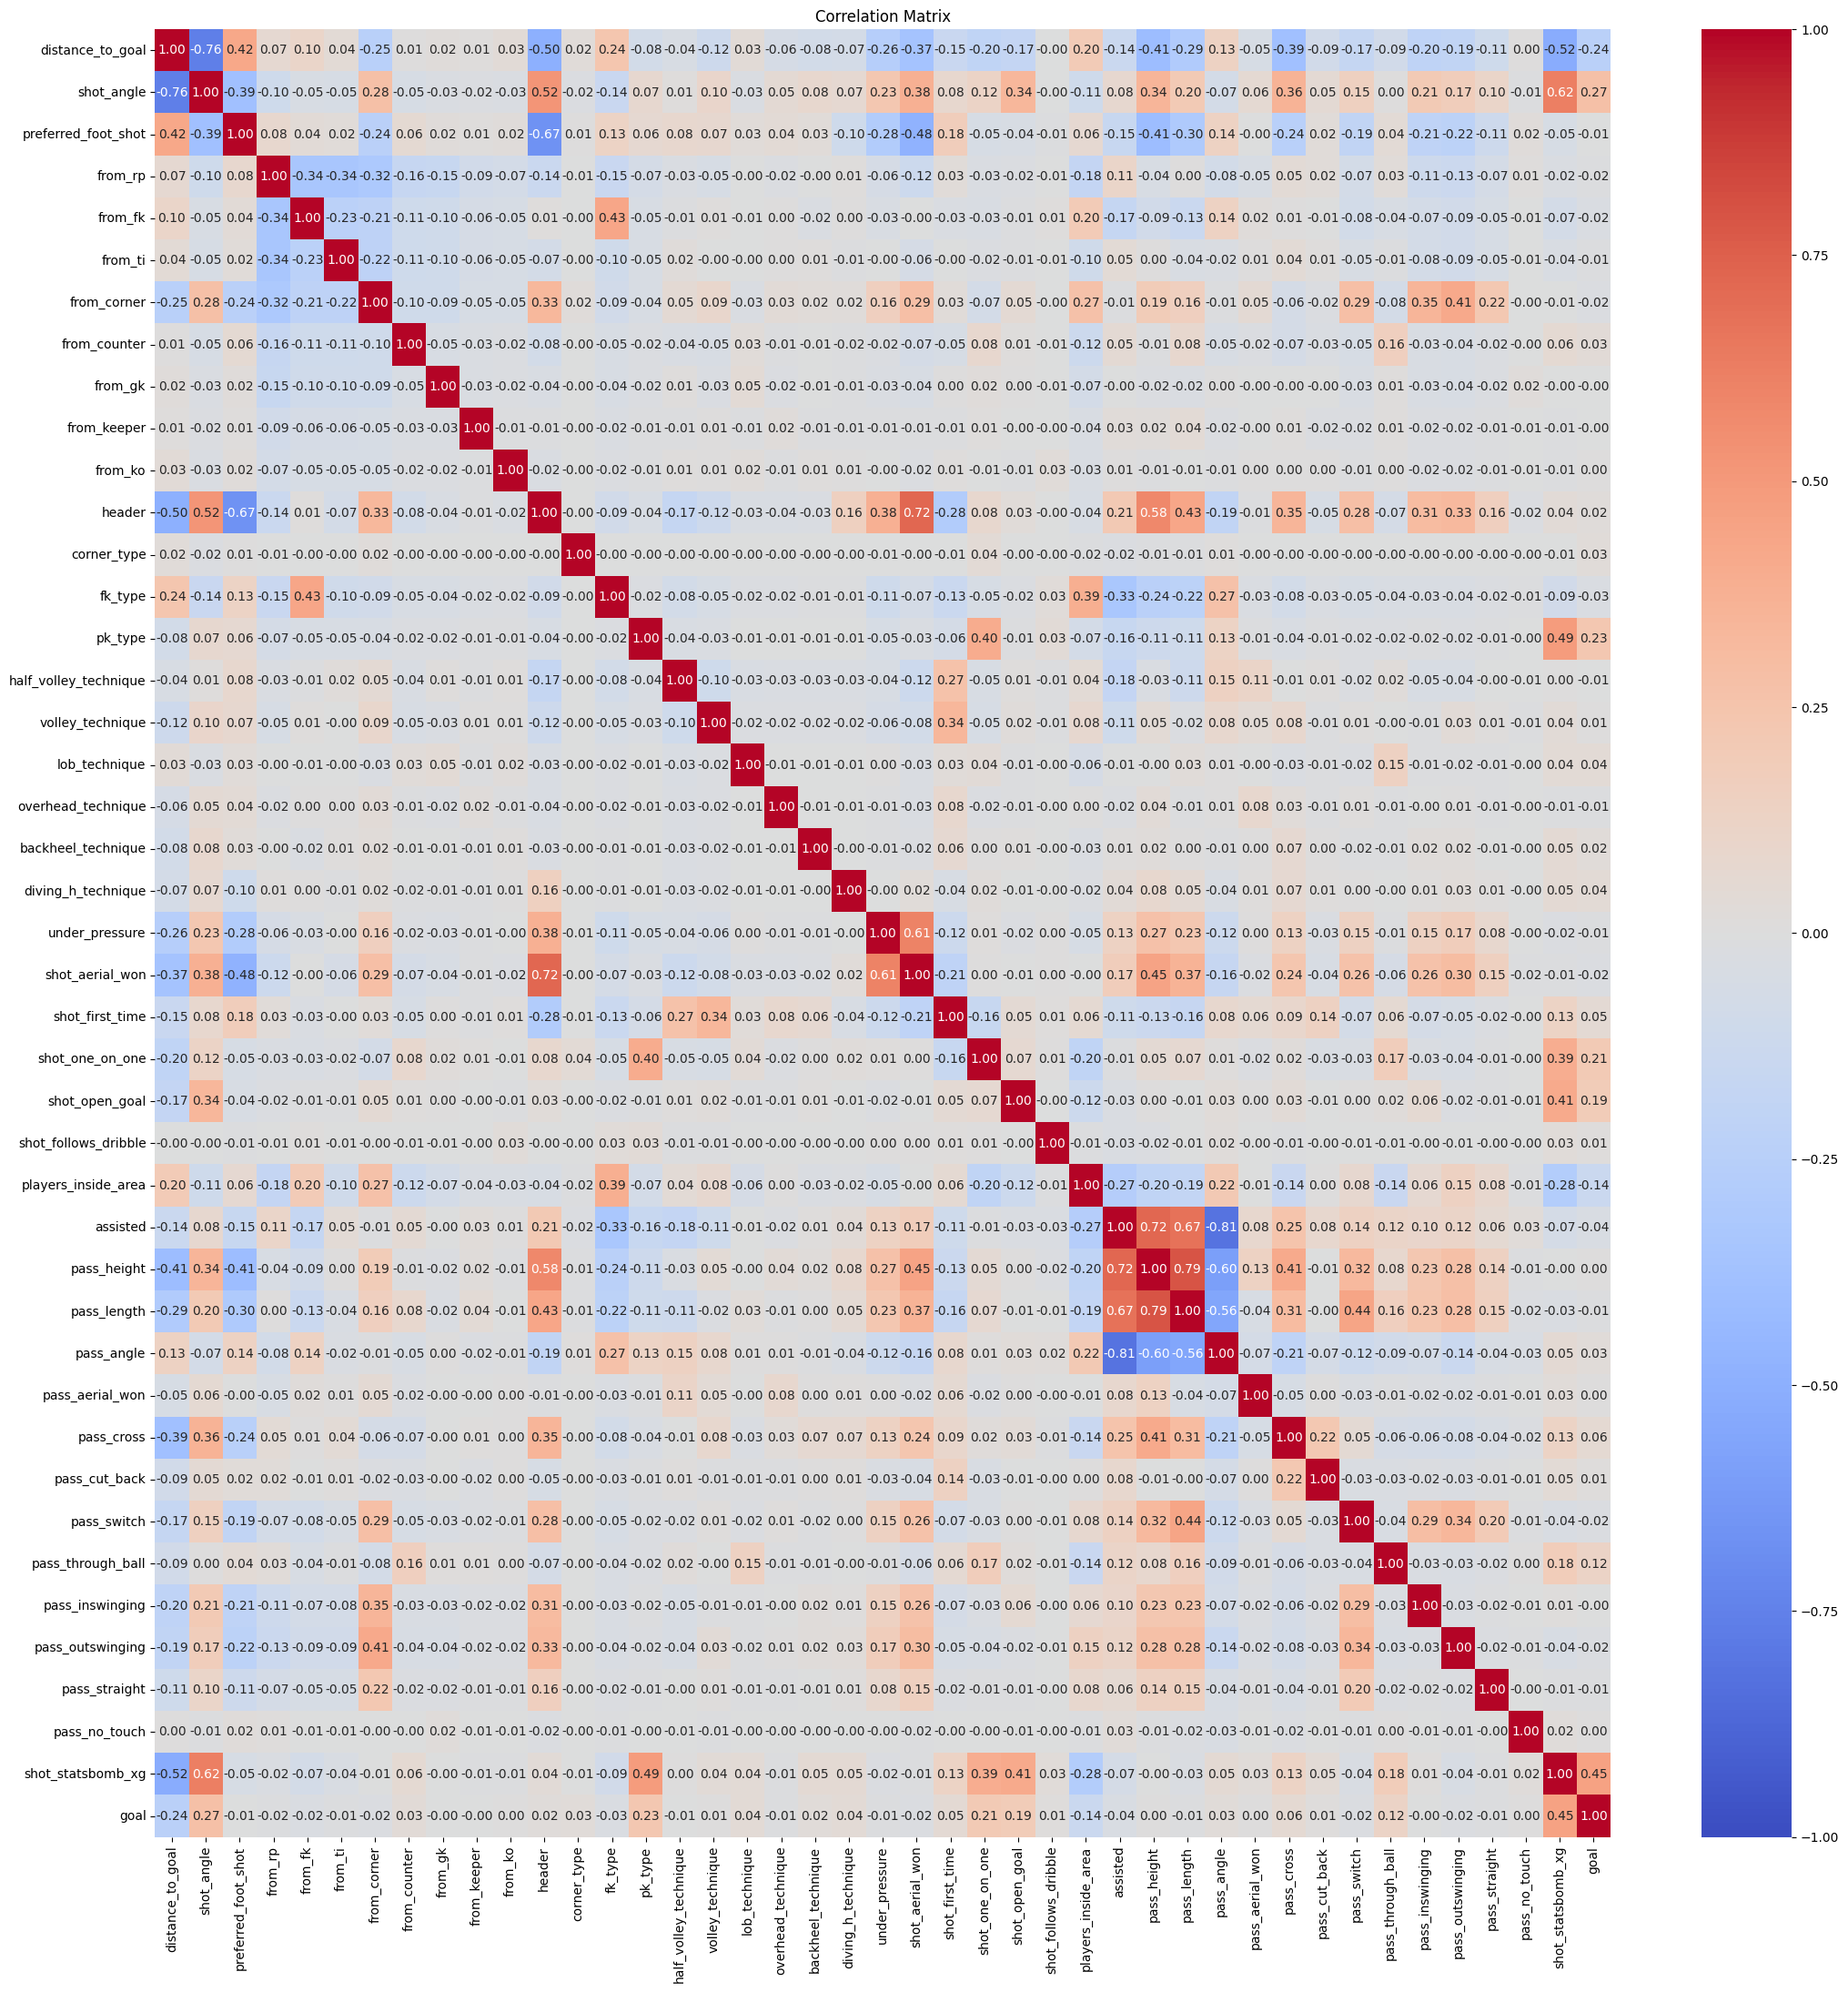

Ligue 1 correlation matrix


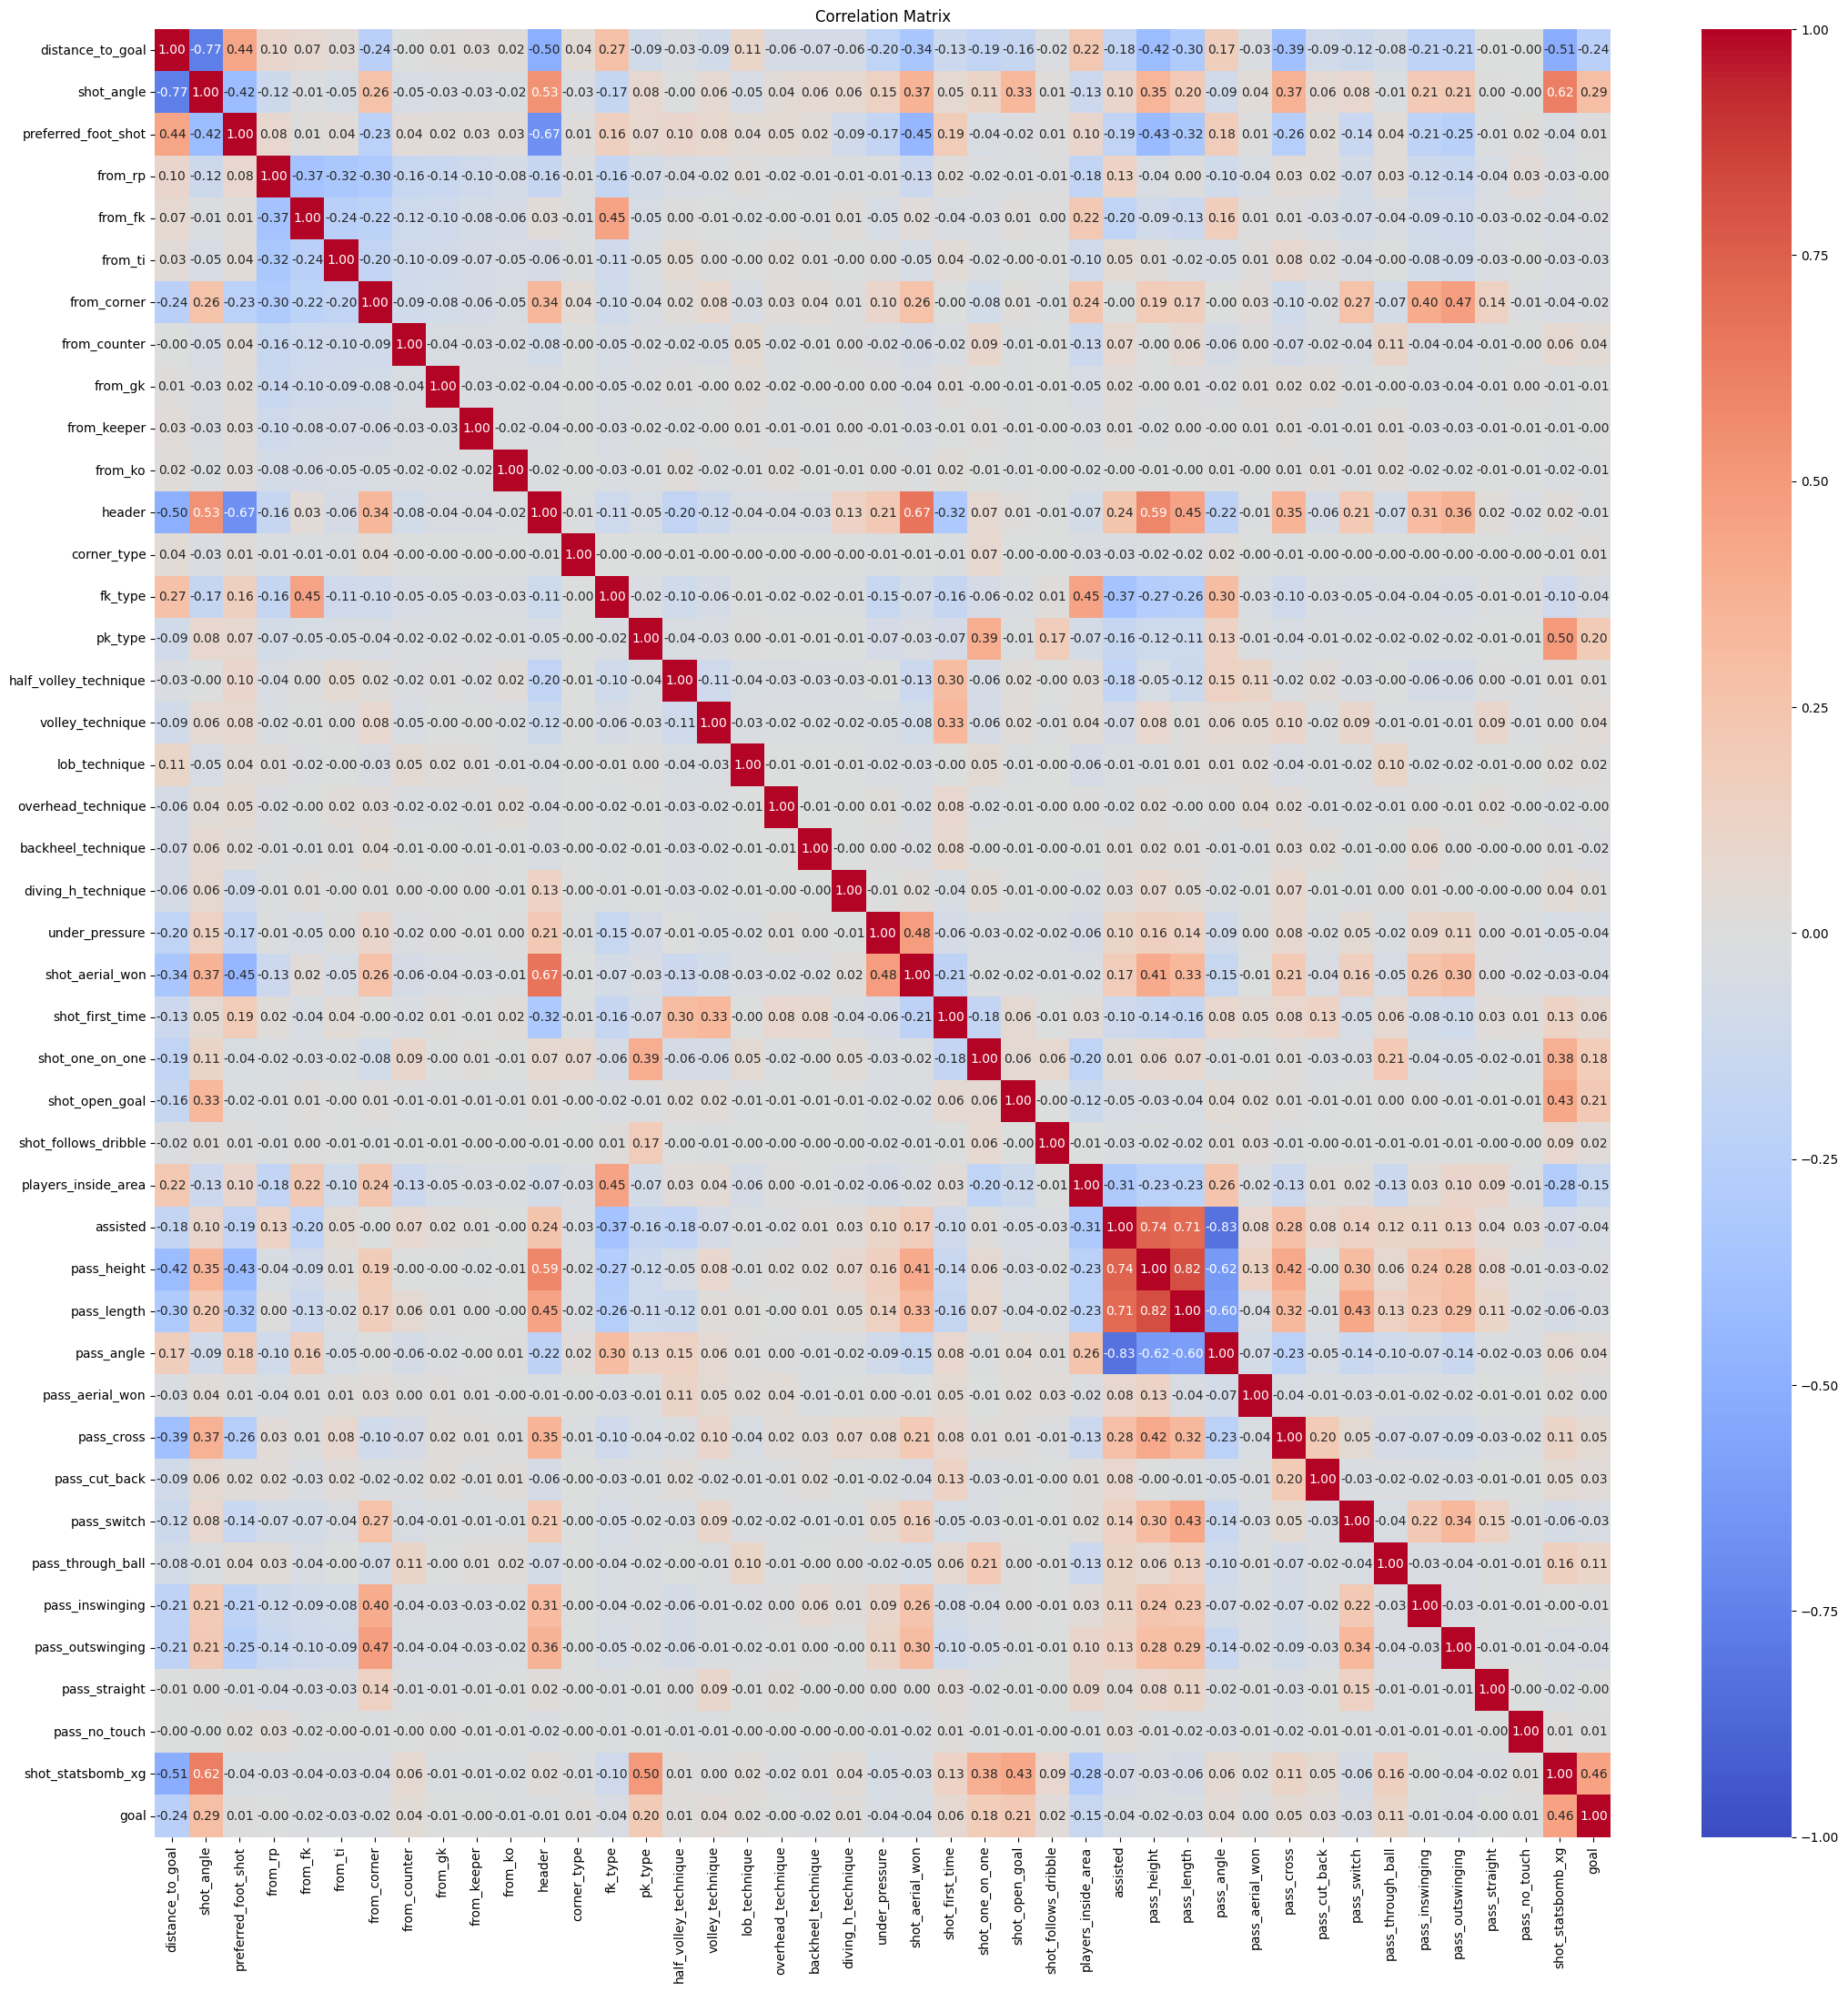

Bundesliga correlation matrix


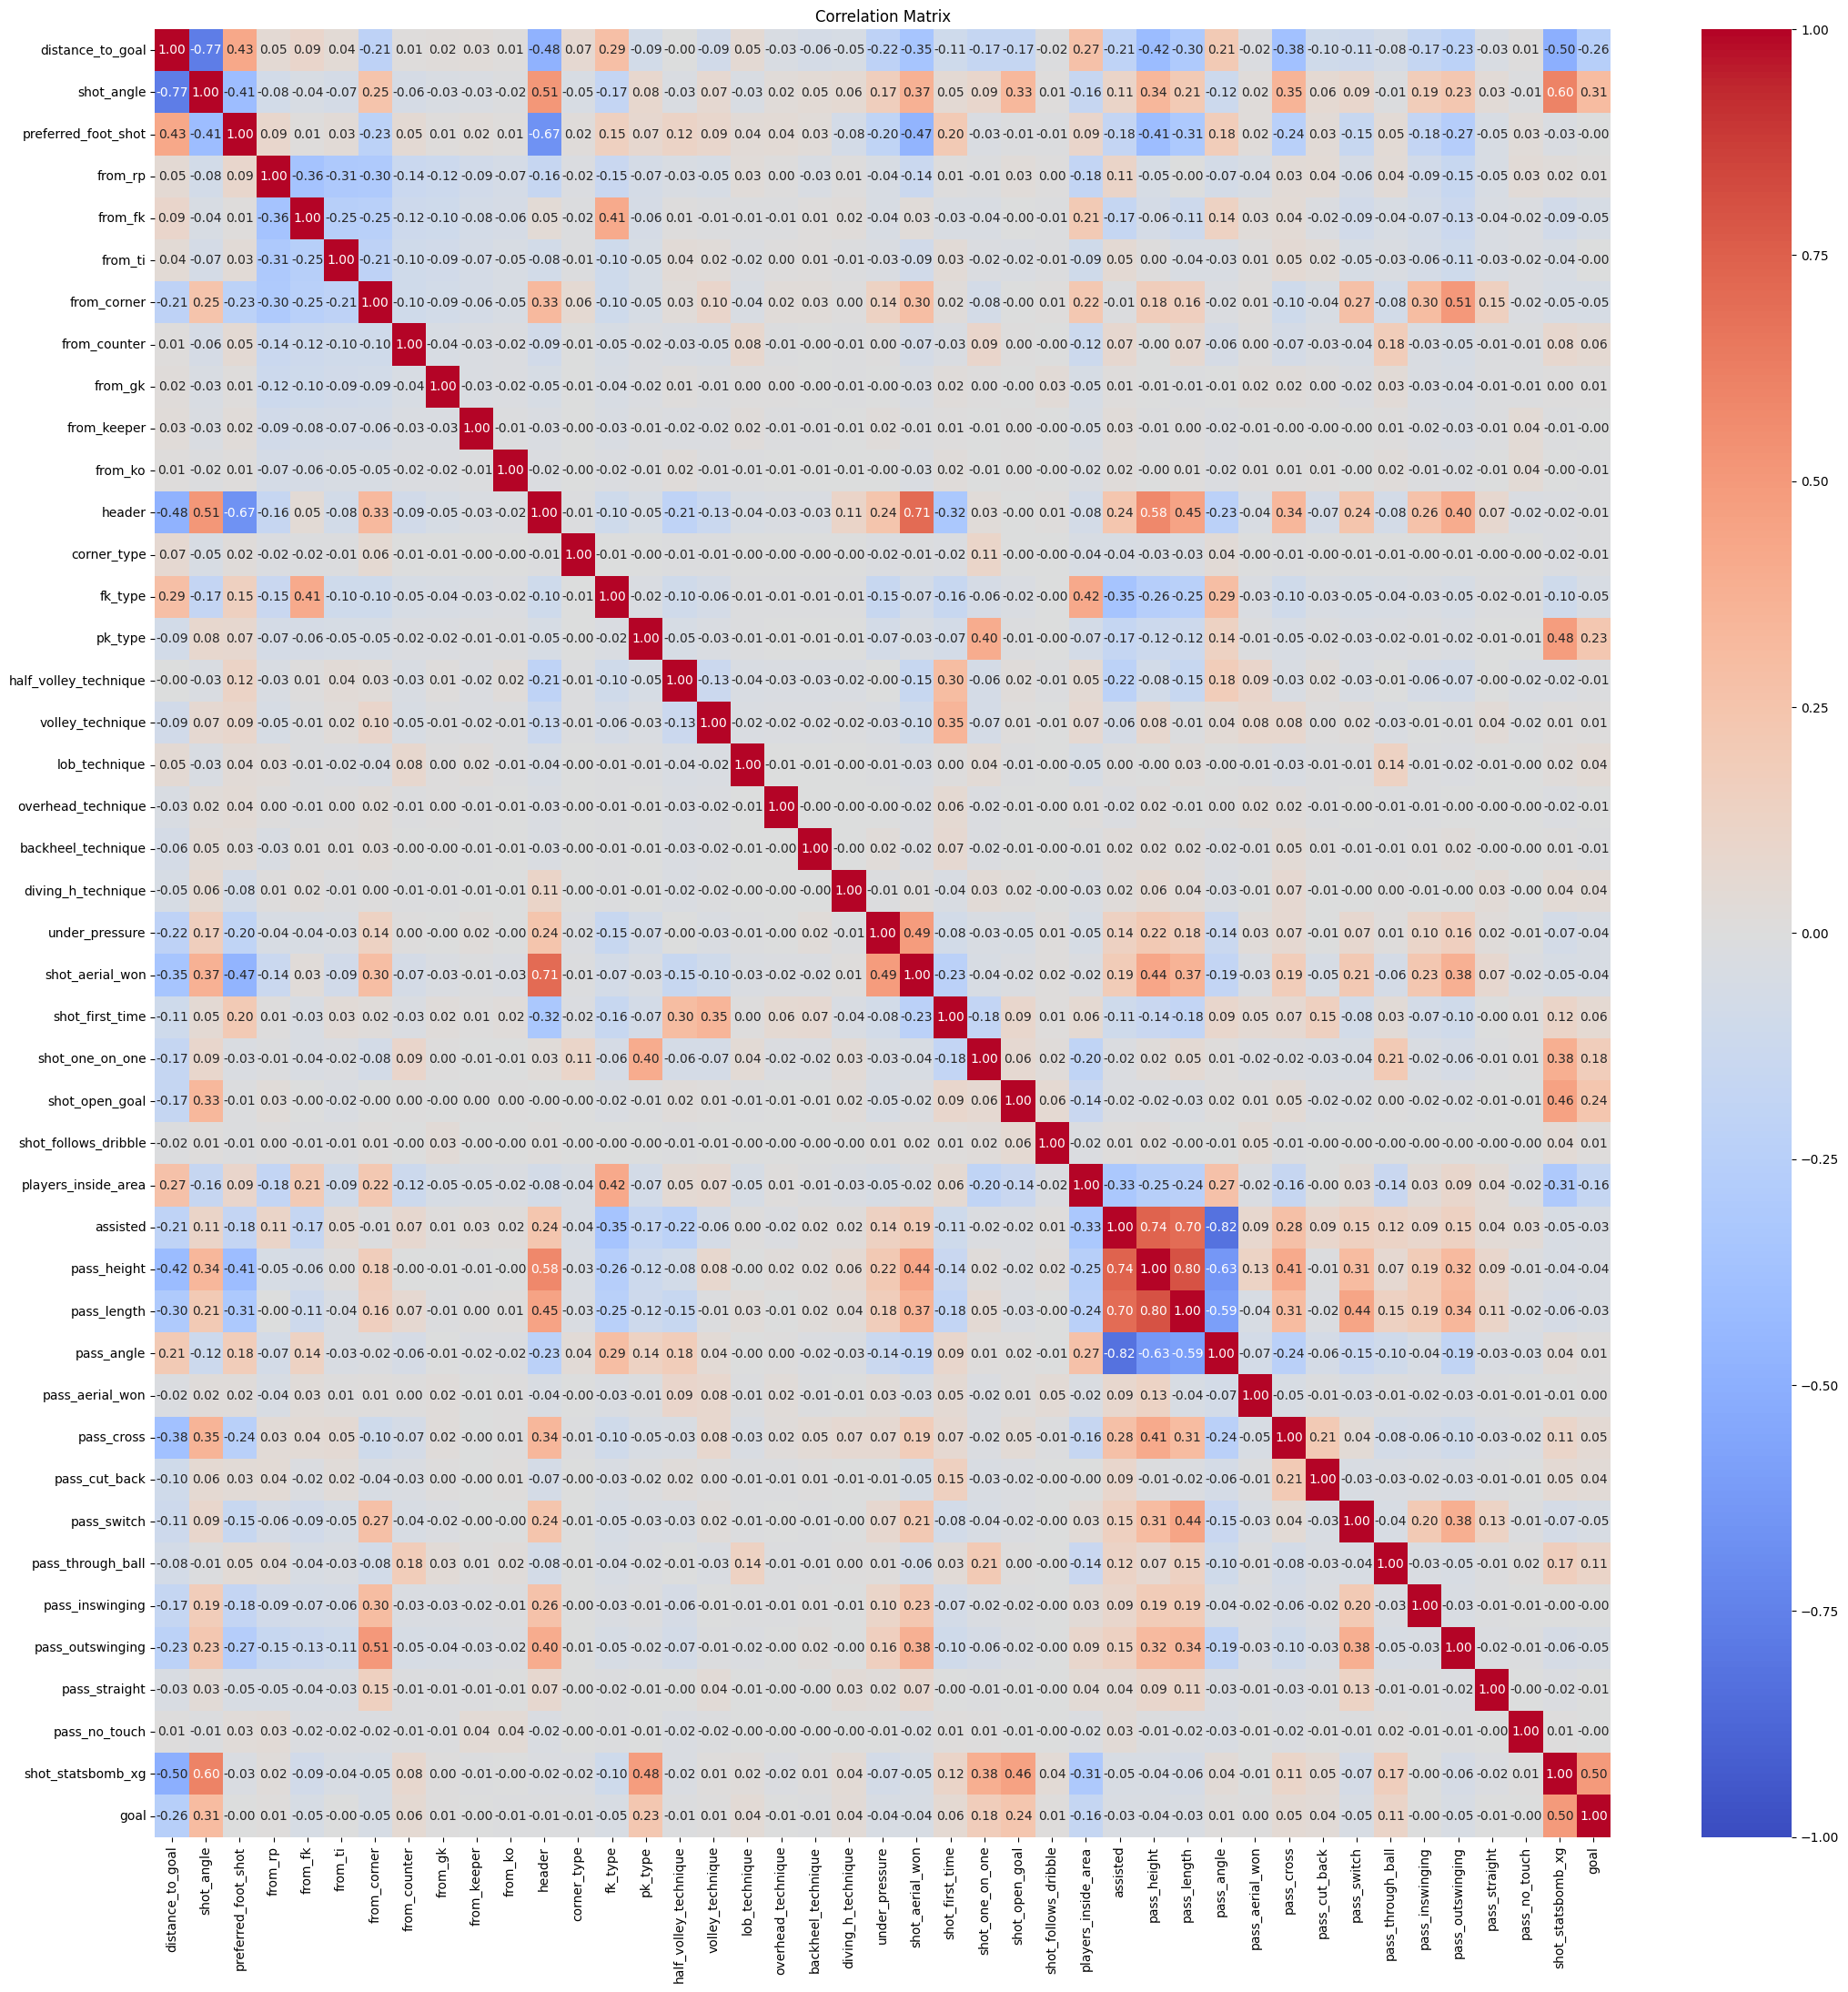

Serie A correlation matrix


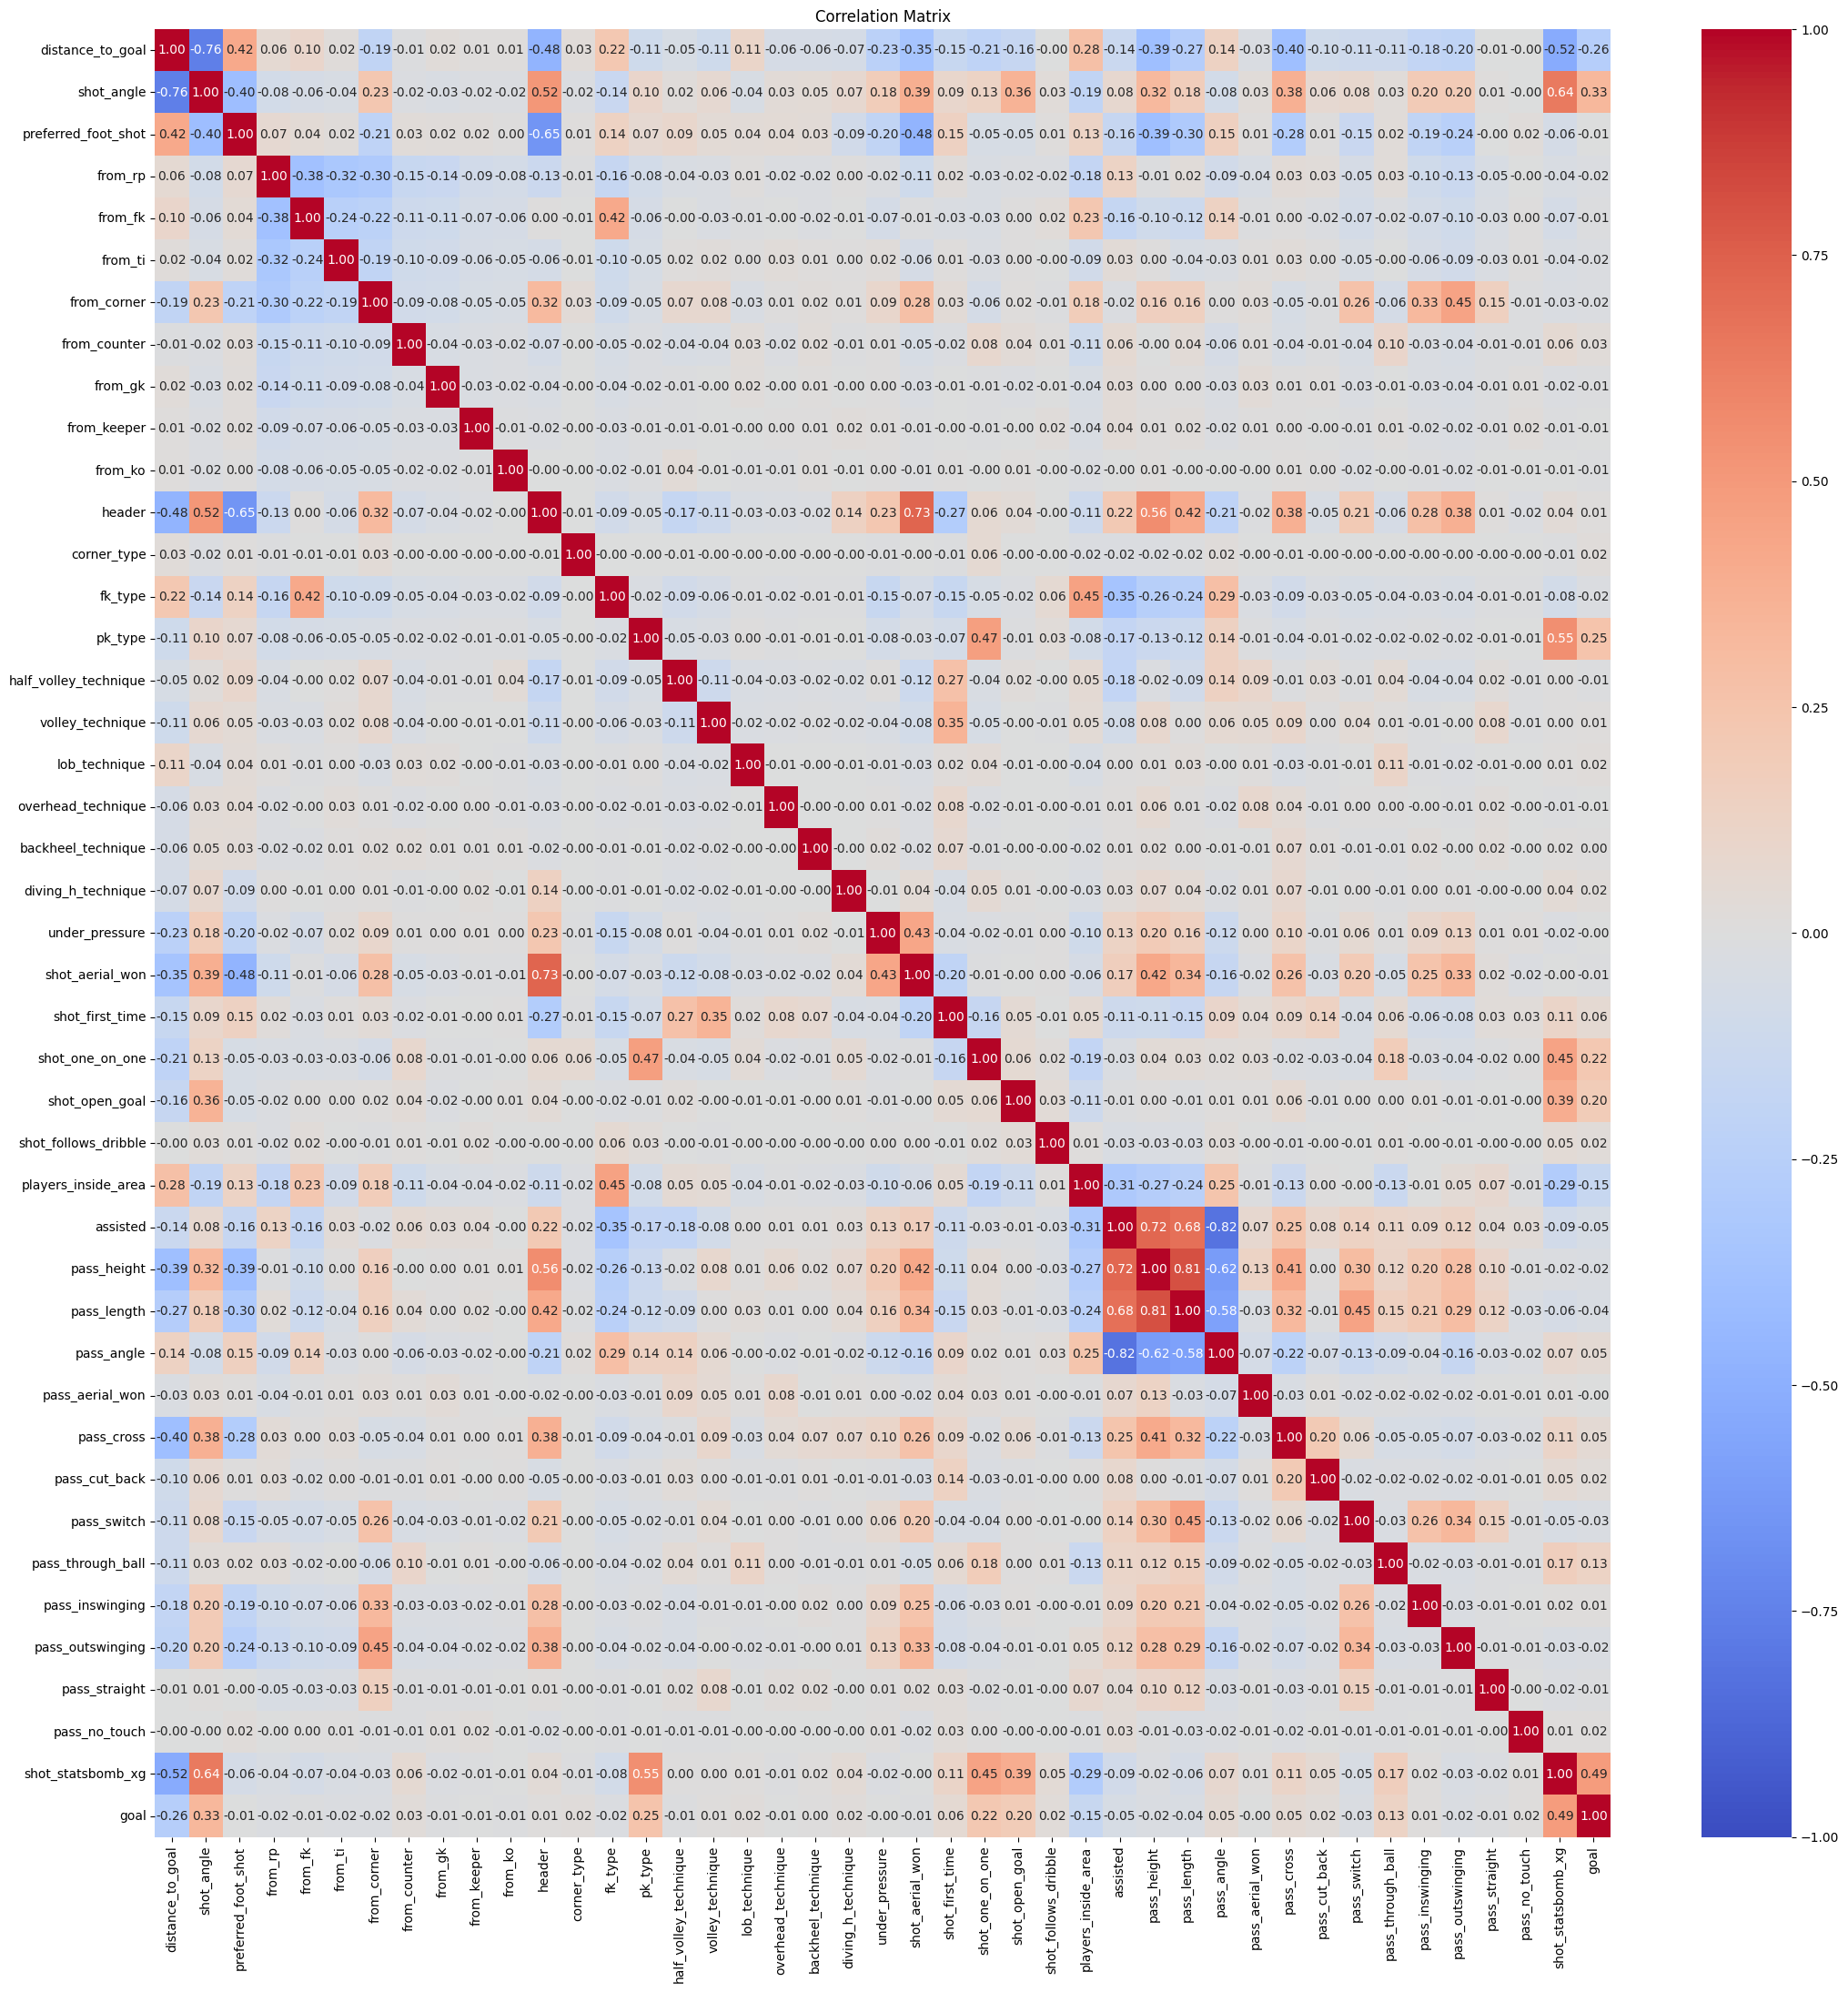

La Liga League correlation matrix


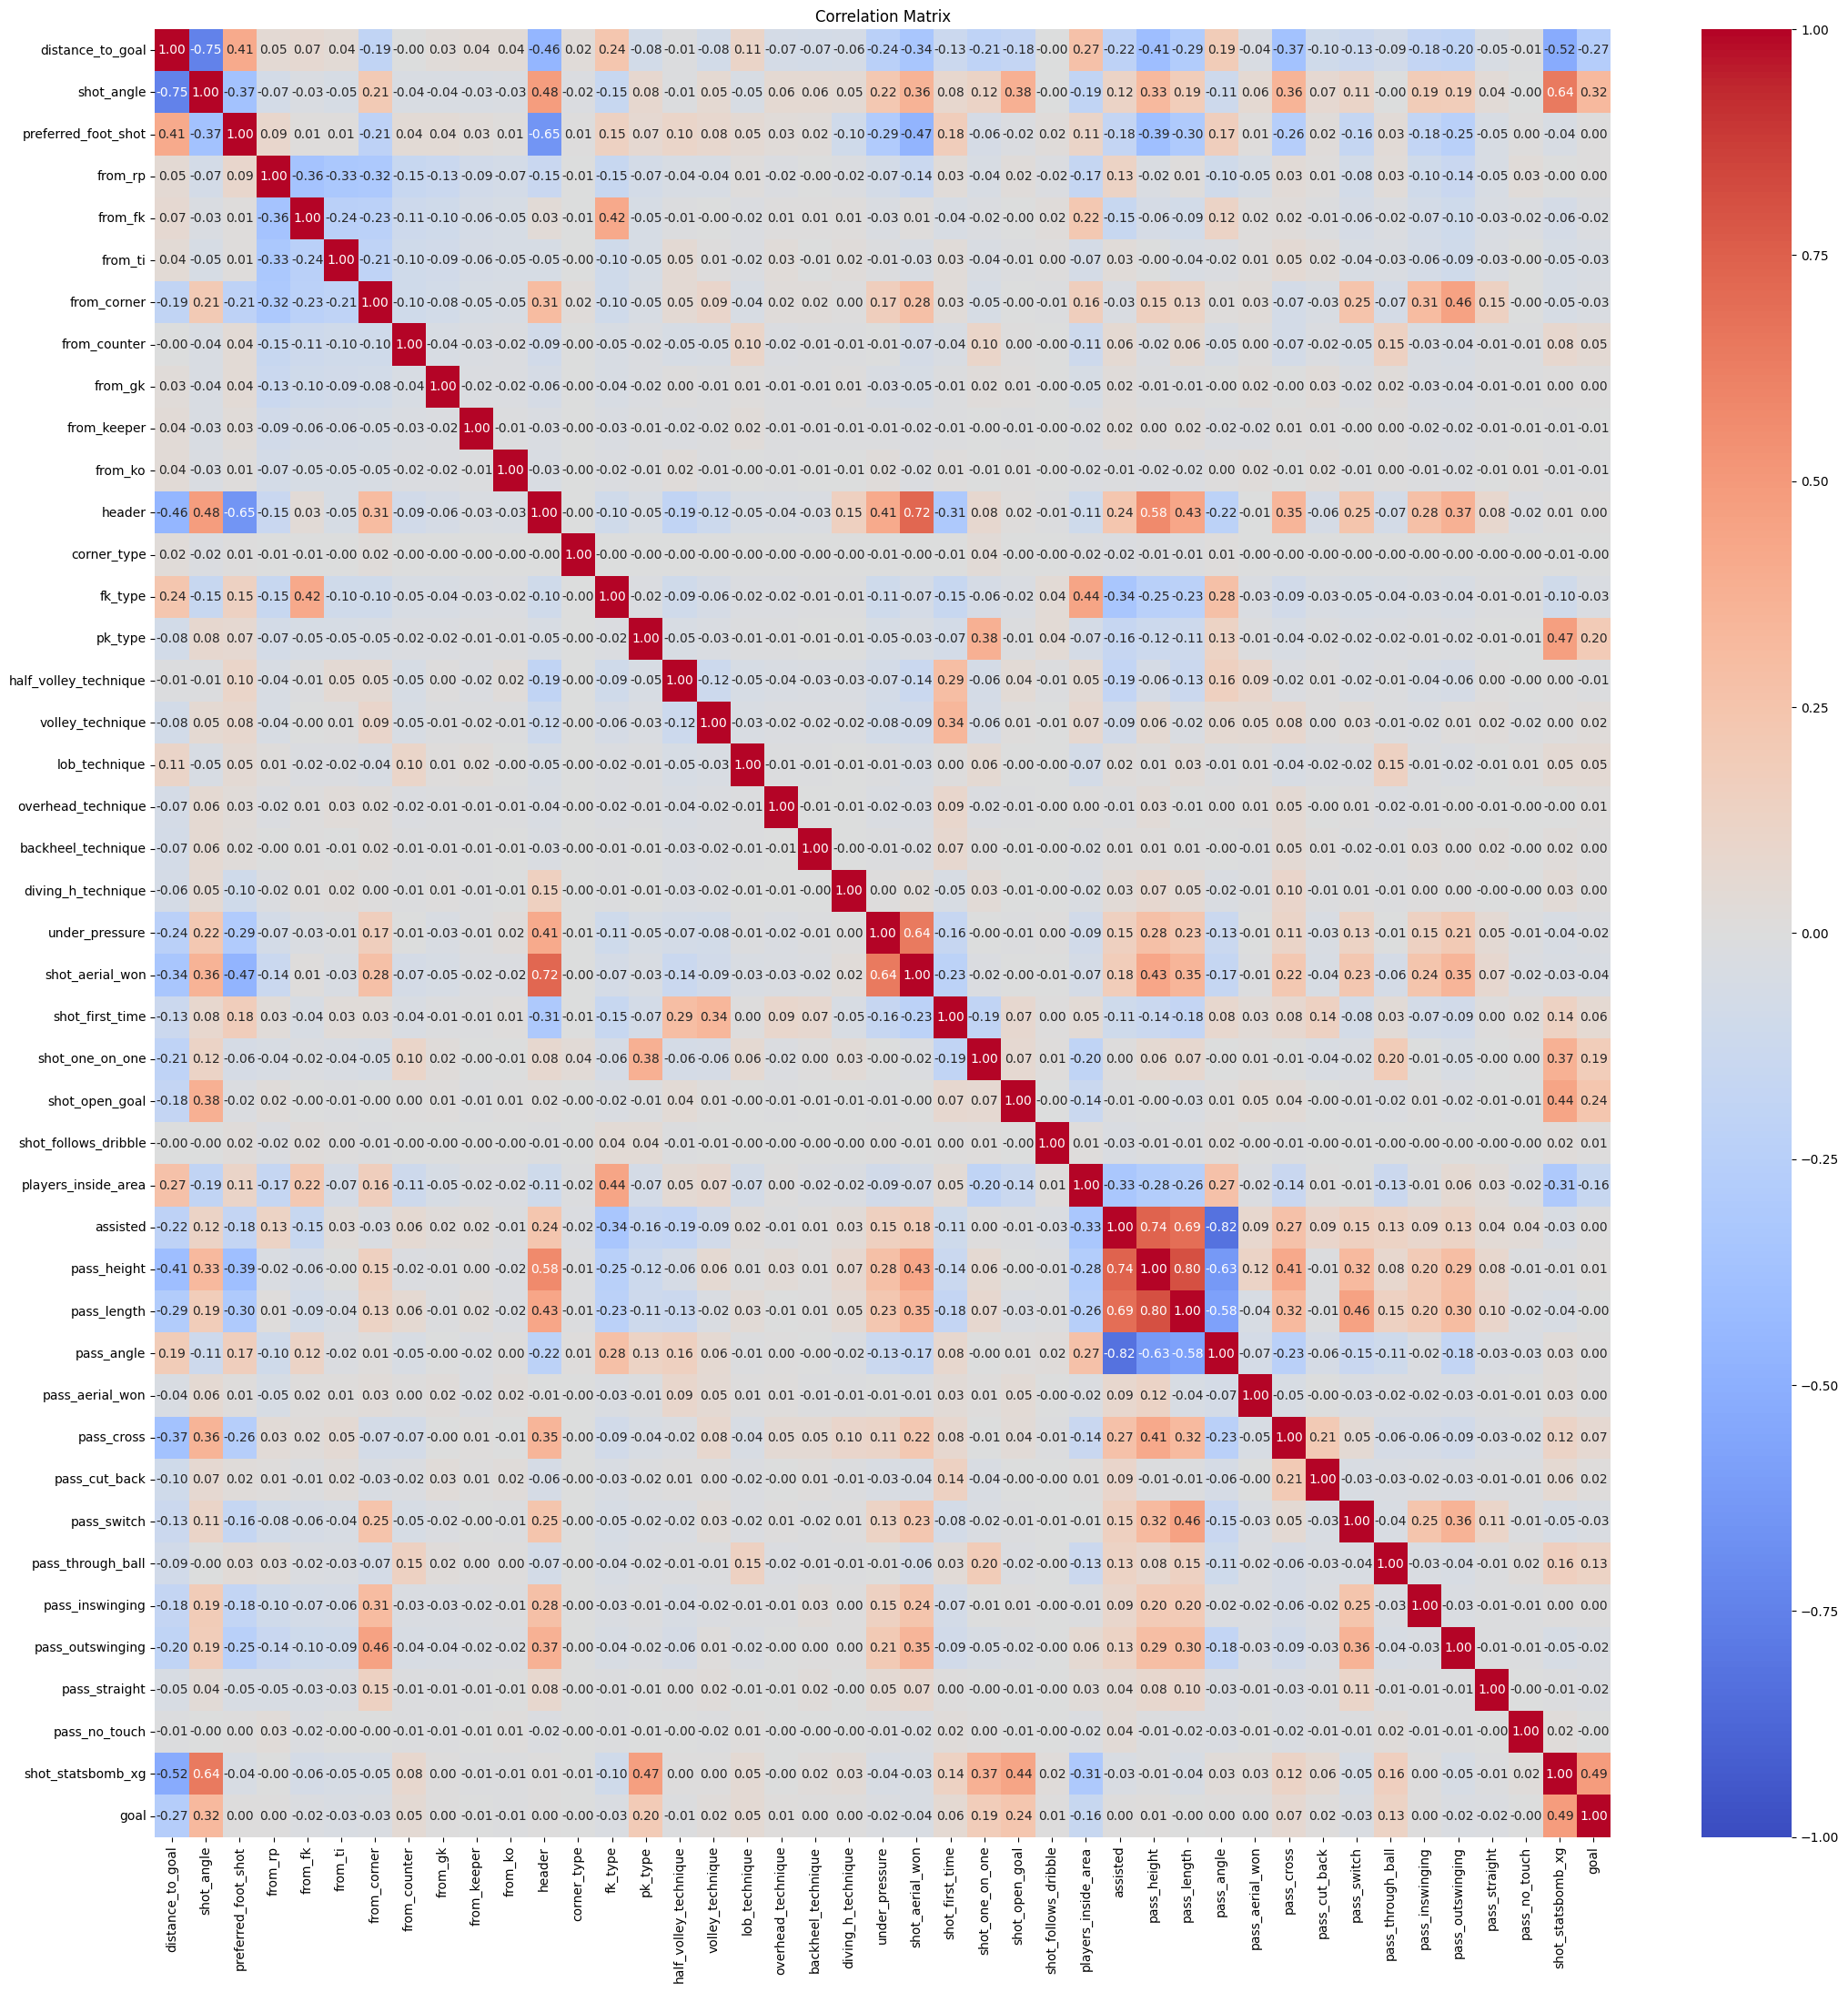

In [24]:
print('Premier League correlation matrix')
PL_viz.correlation()
print('Ligue 1 correlation matrix')
L1_viz.correlation()
print('Bundesliga correlation matrix')
B1_viz.correlation()
print('Serie A correlation matrix')
SA_viz.correlation()
print('La Liga League correlation matrix')
LL_viz.correlation()

Interpreting the 5 correlation matrices reveals that the correlations among key variables are similar across all leagues.<br>
This consistency suggests that the underlying relationships between shot metrics and other features are robust, regardless of league-specific differences, and reinforces the generalizability of our feature selection for modeling xG.

Furthermore, the variables ```assisted```, ```pass_height```, ```pass_length```, and ```pass_angle``` exhibit strong inter-correlations.<br>
This is largely due to the encoding strategy: ```assisted``` indicates the presence of a pass leading to a shot, and when its value is 0, the other variables are assigned predefined values that fall outside the normal range observed when a pass is involved.<br>
Consequently, these variables tend to move together, resulting in the observed strong correlations.

#### Shot and Goal heatmap

In [65]:
def describe_league(df):
    shots = df.count()
    goals = df.filter(F.col('goal')==1).count()
    pens = df.filter(F.col('pk_type')==1).count()
    pens_s = df.filter((F.col('pk_type')==1) & (F.col('goal')==1)).count()
    print(f'Shots : {shots}.')
    print(f'Goals : {goals}.')
    print(f'Goal % : {(goals / shots) * 100 : .2f} %')
    print(f'Penalties : {pens}.')
    print(f'Penalties Scored : {pens_s}.')
    print(f'Penalties Scored % : {(pens_s / pens) * 100 : .2f} %')

Shot and Goal heatmap for Premier League in 2015/2016 season.
Shots : 9908.
Goals : 988.
Goal % :  9.97 %
Penalties : 91.
Penalties Scored : 74.
Penalties Scored % :  81.32 %


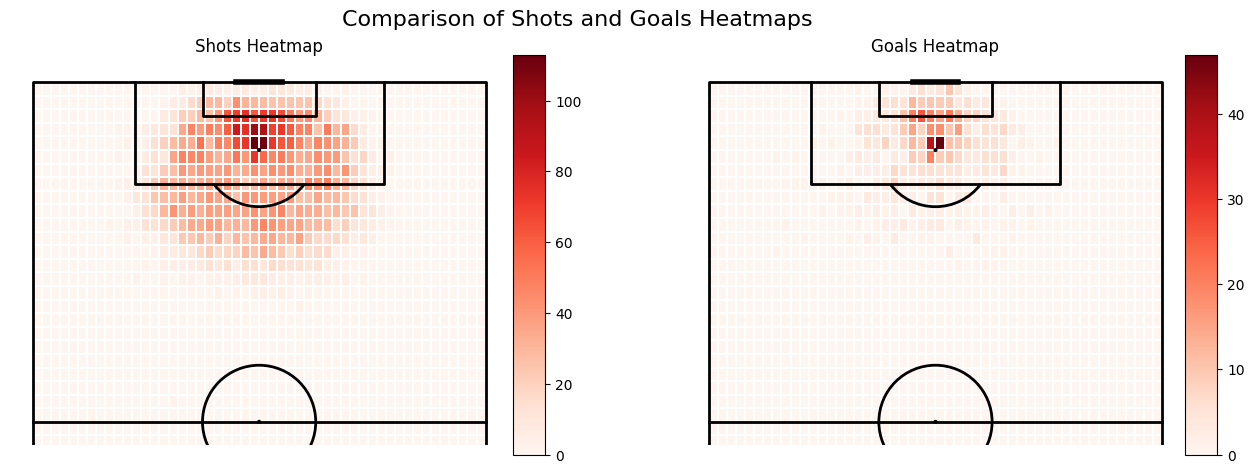

Shot and Goal heatmap for Ligue 1 in 2015/2016 season.
Shots : 8814.
Goals : 916.
Goal % :  10.39 %
Penalties : 91.
Penalties Scored : 64.
Penalties Scored % :  70.33 %


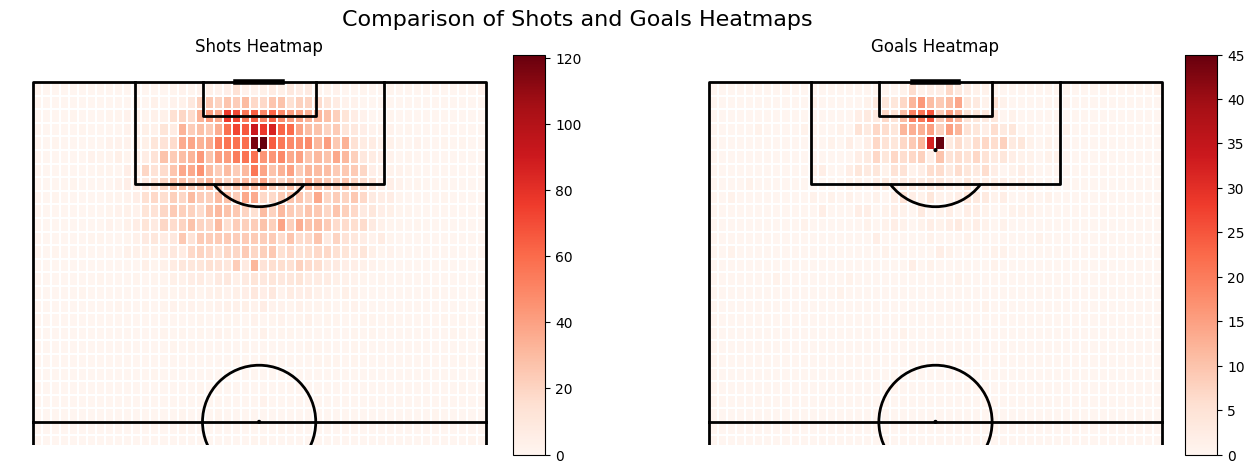

Shot and Goal heatmap for Bundesliga in 2015/2016 season.
Shots : 7831.
Goals : 837.
Goal % :  10.69 %
Penalties : 86.
Penalties Scored : 68.
Penalties Scored % :  79.07 %


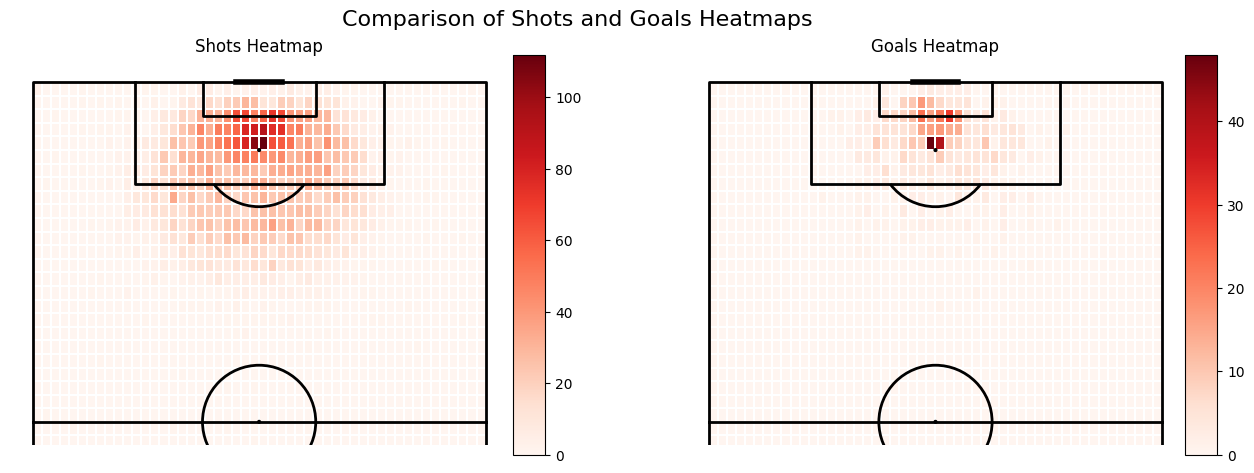

Shot and Goal heatmap for Serie A in 2015/2016 season.
Shots : 9998.
Goals : 951.
Goal % :  9.51 %
Penalties : 121.
Penalties Scored : 93.
Penalties Scored % :  76.86 %


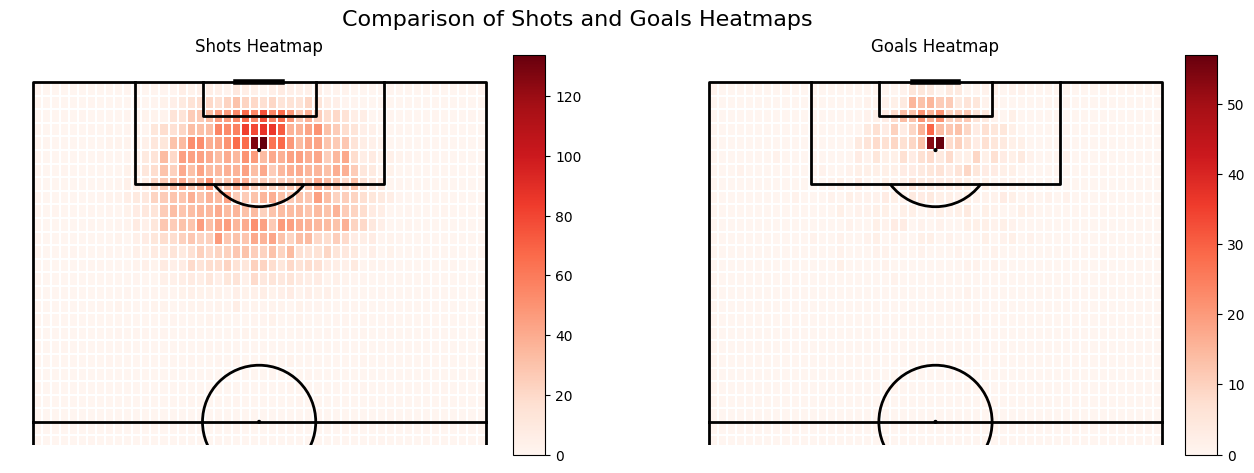

Shot and Goal heatmap for La Liga League in 2015/2016 season.
Shots : 9168.
Goals : 1014.
Goal % :  11.06 %
Penalties : 97.
Penalties Scored : 69.
Penalties Scored % :  71.13 %


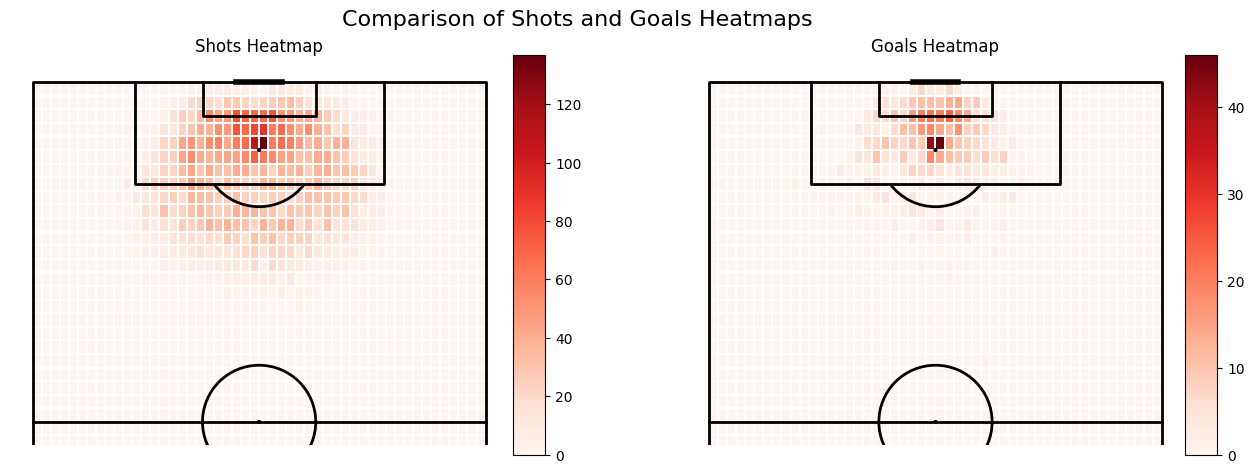

In [67]:
print(f'Shot and Goal heatmap for Premier League in {SEASON} season.')
describe_league(PL.df)
PL_viz.shot_goal_heatmap()

print(f'Shot and Goal heatmap for Ligue 1 in {SEASON} season.')
describe_league(L1.df)
L1_viz.shot_goal_heatmap()

print(f'Shot and Goal heatmap for Bundesliga in {SEASON} season.')
describe_league(B1.df)
B1_viz.shot_goal_heatmap()

print(f'Shot and Goal heatmap for Serie A in {SEASON} season.')
describe_league(SA.df)
SA_viz.shot_goal_heatmap()

print(f'Shot and Goal heatmap for La Liga League in {SEASON} season.')
describe_league(LL.df)
LL_viz.shot_goal_heatmap()

A comparison of the shot and goal heatmaps across Europe’s top five leagues (2015/2016) reveals both similarities and subtle differences.<br>
The ```Premier League``` recorded 9,908 shots with a 9.97% conversion rate, while ```La Liga```’s 9,168 shots yielded the highest conversion rate at 11.06%.<br>
```Serie A``` led in total shots (9,998) yet had a lower conversion rate (9.51%), and the ```Bundesliga```, despite the fewest shots (7,831), maintained a strong 10.69% conversion rate.

Penalty statistics also vary considerably: ```Serie A``` had 121 penalties with a 76.86% success rate, whereas the ```Bundesliga``` saw only 86 penalties but at a higher 79.07% success rate. ```La Liga``` and ```Ligue 1``` had the lowest penalty success rate with 71.13% and 70.33% respectively.<br>
Despite these league-specific figures, the heatmaps consistently show that shots and goals are concentrated in high-probability areas near the goal, highlighting a broadly similar spatial tendency for scoring opportunities across these major competitions.